In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ASNA-hackathon/sample_submission.csv
/kaggle/input/ASNA-hackathon/train.csv
/kaggle/input/ASNA-hackathon/test.csv


In [2]:
#Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
from lightgbm import LGBMClassifier
from statistics import mean
import matplotlib.pyplot as plt
import warnings
import math

In [3]:
df_train = pd.read_csv("/kaggle/input/ASNA-hackathon/train.csv") #7290
df_test = pd.read_csv("/kaggle/input/ASNA-hackathon/test.csv") #1844

In [4]:
df_train['Claim over 1k'].value_counts()

Claim over 1k
0    6458
1     832
Name: count, dtype: int64

In [5]:
for c in df_train.columns:
    if c != 'Effective To Date':
        col_type = df_train[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_train[c] = df_train[c].astype('category')

for c in df_test.columns:
    if c != 'Effective To Date':
        col_type = df_test[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_test[c] = df_test[c].astype('category')

In [6]:
cols_with_missing = [col for col in df_train.columns 
                                 if df_train[col].isnull().any()]                                  
candidate_train_predictors = df_train.drop(['CustomerID', 'Claim over 1k', 'Coverage', 'Education', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size'] + cols_with_missing, axis=1)
candidate_test_predictors = df_test.drop(['CustomerID', 'Coverage', 'Education', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size'] + cols_with_missing, axis=1)

In [7]:
candidate_train_predictors['Effective To Date'] = pd.to_datetime(candidate_train_predictors['Effective To Date'])
candidate_train_predictors['Current Date'] = '10/1/2024'
candidate_train_predictors['Current Date'] = pd.to_datetime(candidate_train_predictors['Current Date'])

# create new columns
candidate_train_predictors['clv_avg'] = candidate_train_predictors['Customer Lifetime Value'] / candidate_train_predictors['Months Since Policy Inception']
candidate_train_predictors['complaints_avg'] = candidate_train_predictors['Number of Open Complaints'] / candidate_train_predictors['Number of Policies']
candidate_train_predictors = candidate_train_predictors.drop(['Number of Open Complaints'], axis=1)
candidate_train_predictors['Policy Age (in months)'] = ((candidate_train_predictors['Current Date'] - candidate_train_predictors['Effective To Date']) / pd.Timedelta(days=30.44)).astype(int)
candidate_train_predictors = candidate_train_predictors.drop(['Current Date', 'Effective To Date'], axis=1)
# remove noise
candidate_train_predictors = candidate_train_predictors.drop(['State', 'Policy', 'Sales Channel', 'Renew Offer Type', 'Policy Type'], axis=1)

In [8]:
candidate_test_predictors['Effective To Date'] = pd.to_datetime(candidate_test_predictors['Effective To Date'])
candidate_test_predictors['Current Date'] = '10/1/2024'
candidate_test_predictors['Current Date'] = pd.to_datetime(candidate_test_predictors['Current Date'])

# create new columns
candidate_test_predictors['clv_avg'] = candidate_test_predictors['Customer Lifetime Value'] / candidate_test_predictors['Months Since Policy Inception']
candidate_test_predictors['complaints_avg'] = candidate_test_predictors['Number of Open Complaints'] / candidate_test_predictors['Number of Policies']
candidate_test_predictors = candidate_test_predictors.drop(['Number of Open Complaints'], axis=1)
candidate_test_predictors['Policy Age (in months)'] = ((candidate_test_predictors['Current Date'] - candidate_test_predictors['Effective To Date']) / pd.Timedelta(days=30.44)).astype(int)
candidate_test_predictors = candidate_test_predictors.drop(['Current Date', 'Effective To Date'], axis=1)
# remove noise
candidate_test_predictors = candidate_test_predictors.drop(['State', 'Policy', 'Sales Channel', 'Renew Offer Type', 'Policy Type'], axis=1)

In [9]:
candidate_train_predictors

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,clv_avg,complaints_avg,Policy Age (in months)
0,3622.69,No,0,2,Employed,F,65163,Married,4,107,1,1,33.856916,3.0,9
1,10610.21,No,0,0,Unemployed,M,0,Single,26,14,7,1,757.872143,0.0,9
2,13868.02,No,1,1,Employed,M,81196,Single,11,38,3,1,364.947895,0.0,9
3,3119.69,No,0,2,Unemployed,F,0,Single,16,32,1,1,97.490313,0.0,9
4,5999.04,No,2,2,Employed,M,62618,Married,45,126,1,1,47.611429,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,No,0,2,Unemployed,F,0,Single,0,28,2,1,982.162143,0.5,0
7286,11750.03,No,0,3,Employed,F,83561,Married,9,107,2,1,109.813364,0.0,0
7287,7757.04,No,0,2,Employed,F,69302,Married,23,119,9,1,65.185210,0.0,0
7288,3465.16,No,0,0,Employed,F,28856,Married,19,89,1,2,38.934382,0.0,0


# Modelliing

In [10]:
y = df_train['Claim over 1k']
X = candidate_train_predictors
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

In [11]:
lgbm = LGBMClassifier(objective='binary')
lgbm.fit(train_X,train_y)
val_y_predlgbm = lgbm.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
Recall of LightGBM on test set: 0.5602409638554217
Precision of LightGBM on test set: 0.72
F1 score of LightGBM on test set: 0.92
ROC-AUC of LightGBM on test set: 0.7661885933828191
PR-AUC of LightGBM on test set: 0.6656198917595927


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


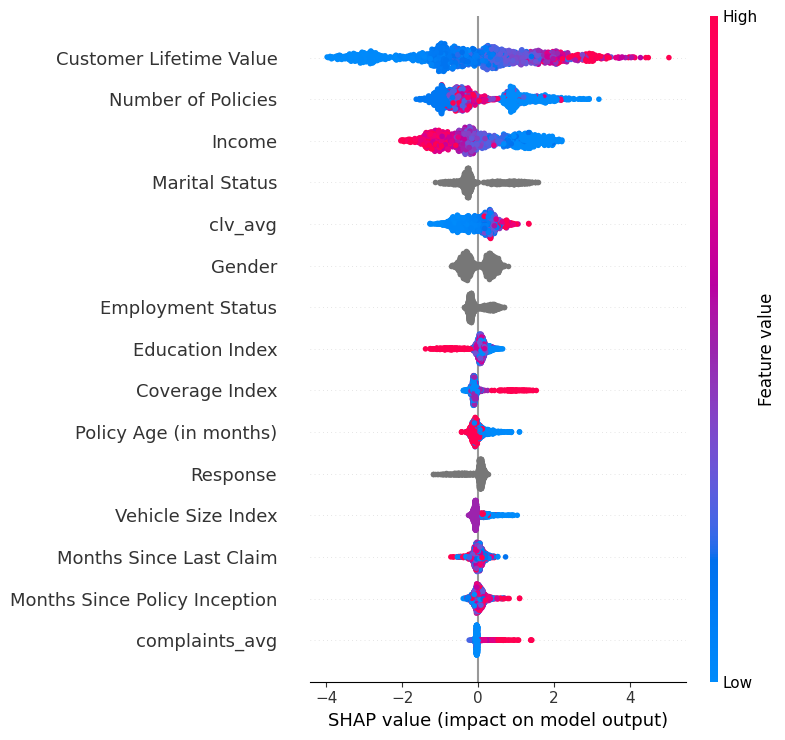

In [12]:
import shap
explainer = shap.Explainer(lgbm)
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values[1], val_X)
# shap.summary_plot(shap_values[1], val_X, max_display=15)

<Axes: >

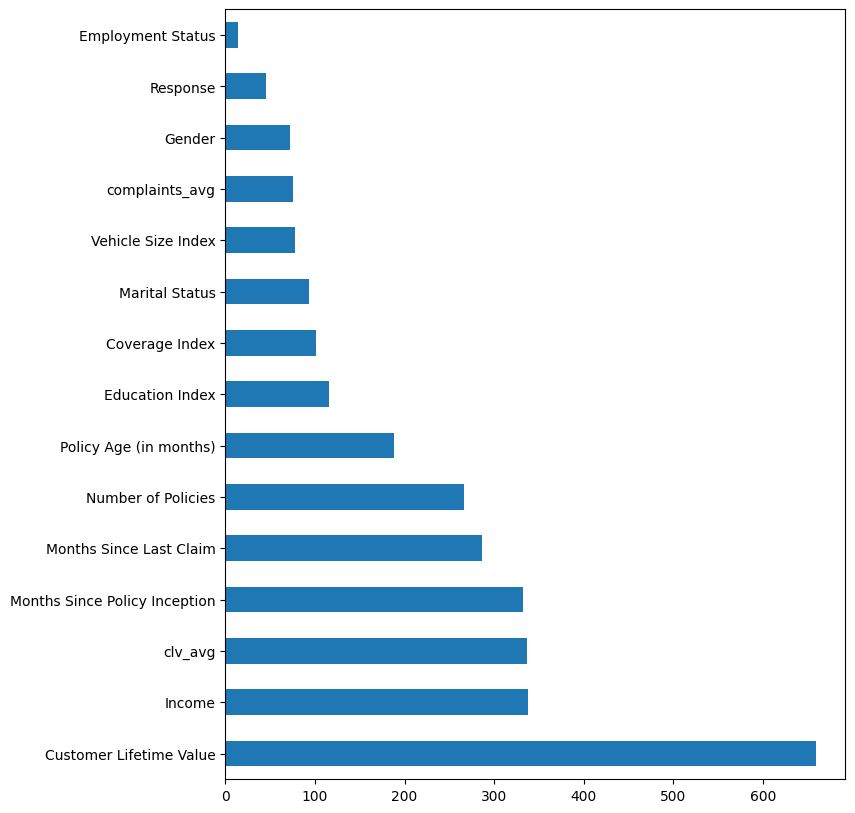

In [13]:
feat_imp = pd.Series(lgbm.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [14]:
# from sklearn.model_selection import GridSearchCV

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define a range of values for the hyperparameters to search through
# param_grid = {
#     'num_leaves': [5, 20, 31, 63, 127],
#     "max_depth": [-1, 3, 5],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 150]
# }

# # Initialize an empty dictionary to store the best hyperparameters and their values
# best_hyperparameters = {}
# best_values = {}
 
# # Initialize the LightGBM classifier
# lgb_classifier = lgb.LGBMClassifier(objective='binary', random_state=42)
 
# # Initialize GridSearchCV for hyperparameters
# grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
#                            scoring='accuracy', cv=5)
 
# # Fit the model to the training data to search for the best hyperparameters
# grid_search.fit(X_train, y_train)
 
# # Get the best hyperparameters and their values
# best_params = grid_search.best_params_
# best_hyperparameters = list(best_params.keys())
# best_values = list(best_params.values())

In [15]:
# best_params
# {'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 127}
# {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}

In [16]:
best_params = {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(train_X, train_y)

val_y_predlgbmht = best_model.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbmht, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbmht)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbmht,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbmht))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbmht, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
Recall of LightGBM on test set: 0.536144578313253
Precision of LightGBM on test set: 0.75
F1 score of LightGBM on test set: 0.92
ROC-AUC of LightGBM on test set: 0.7564623820358833
PR-AUC of LightGBM on test set: 0.6684279046538542


In [17]:
print(f"Confusion matrix\n {confusion_matrix(val_y, val_y_predlgbm)}\n")

Confusion matrix
 [[1256   36]
 [  73   93]]



In [18]:
predictions = best_model.predict(candidate_test_predictors)
output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
output.to_csv('submission.csv', index=False)

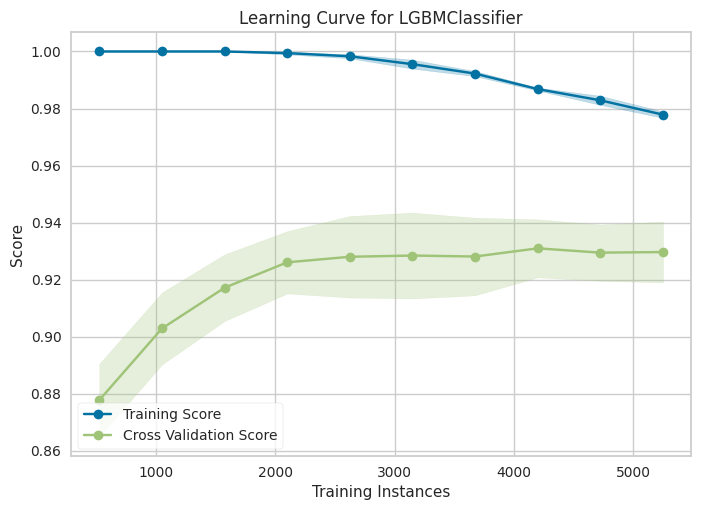

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [19]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=150, num_leaves=31, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

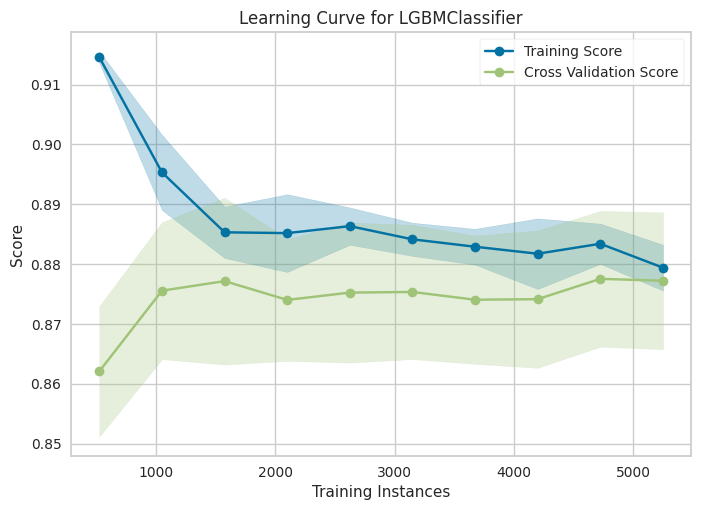

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [20]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

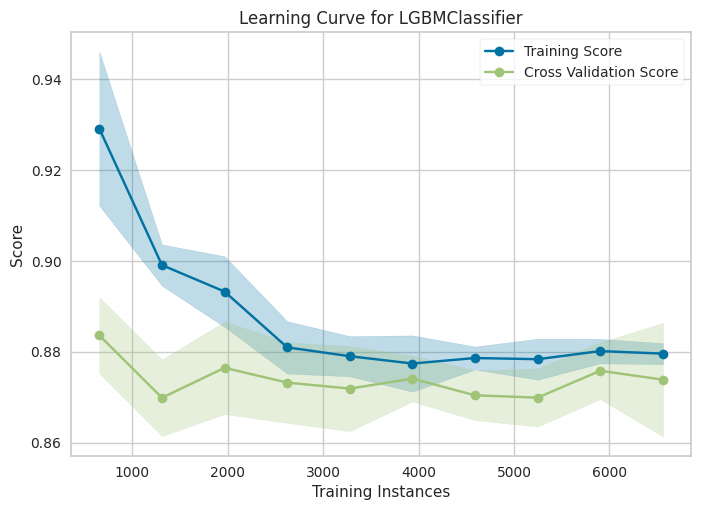

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [21]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

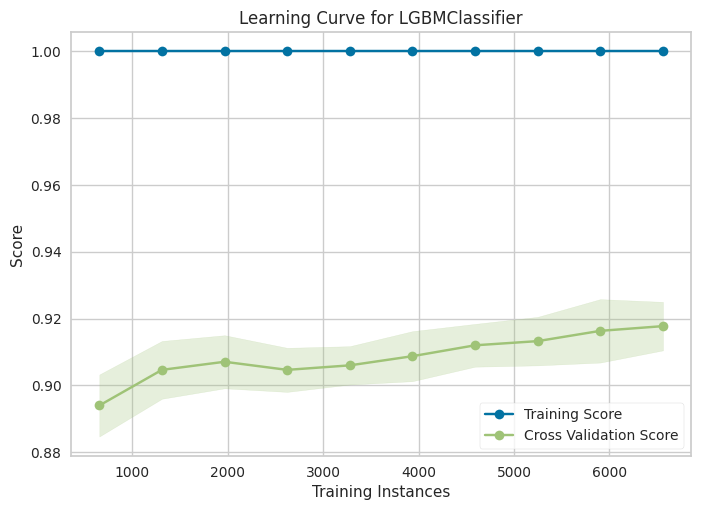

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [22]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.2, n_estimators=100, num_leaves=127, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

Resampling

In [23]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [24]:
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
train_X, train_y = oversample.fit_resample(X, y)
# Build the model with the random forest regression algorithm:
lgbm = LGBMClassifier(objective='binary')
lgbm.fit(train_X,train_y)
val_y_predlgbm = lgbm.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6458, number of negative: 6458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 12916, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Recall of LightGBM on test set: 0.9879518072289156
Precision of LightGBM on test set: 0.71
F1 score of LightGBM on test set: 0.96
ROC-AUC of LightGBM on test set: 0.968434107948823
PR-AUC of LightGBM on test set: 0.8511835138011339


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


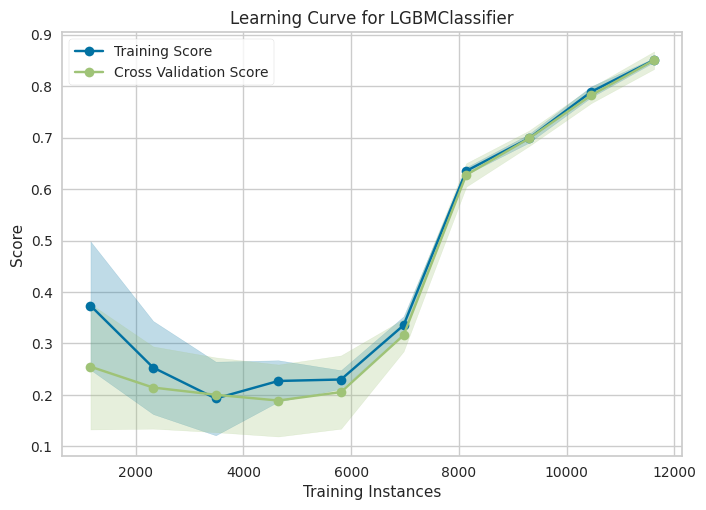

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [25]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='recall', train_sizes=sizes, n_jobs=4
)

visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

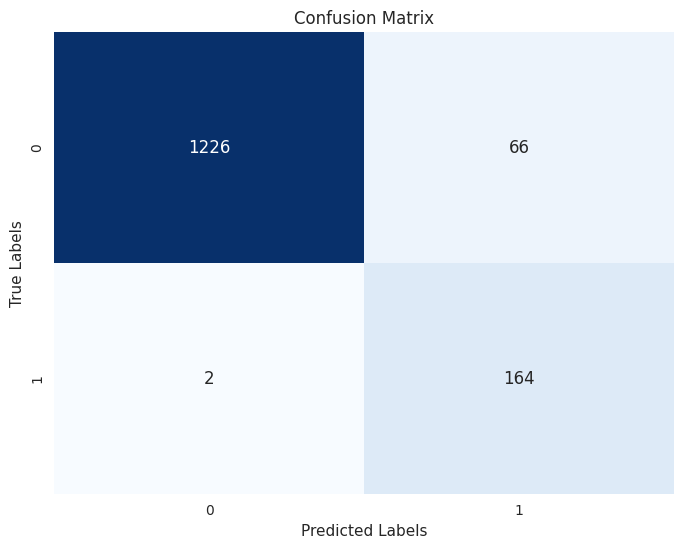

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(val_y, val_y_predlgbm)
conf_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


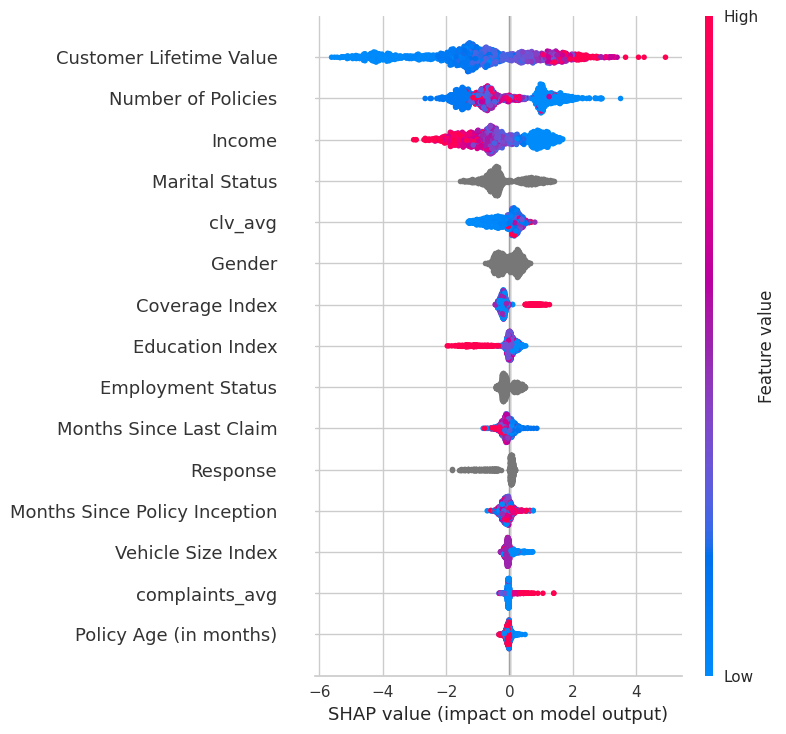

In [27]:
import shap
explainer = shap.Explainer(lgbm)
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values[1], val_X, max_display=15)

In [28]:
# predictions = lgbm.predict(candidate_test_predictors)
# output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
# output.to_csv('submission.csv', index=False)

In [29]:
# # https://www.kaggle.com/code/mlisovyi/beware-of-categorical-features-in-lgbm
# fit_params={"eval_metric" : 'auc', 
#             "eval_set" : [(val_X,val_y)],
#             'eval_names': ['valid'],
#             'feature_name': 'auto', # that's actually the default
#             'categorical_feature': ['State', 'Response', 'Coverage', 'Education', 'Employment Status',
#        'Gender', 'Marital Status', 'Policy Type', 'Policy', 'Sales Channel',
#        'Vehicle Size', 'Renew Offer Type']
#            }

In [30]:
# #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
# clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
#                          random_state=314, 
#                          silent=True, 
#                          metric='None', 
#                          n_jobs=4, 
#                          n_estimators=1000,
#                          colsample_bytree=0.9,
#                          subsample=0.9,
#                          learning_rate=0.1)

In [31]:
# #force larger number of max trees and smaller learning rate
# clf.fit(train_X, train_y, **fit_params)

# val_y_predlgbm = lgbm.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [32]:
# predictions = clf.predict(candidate_test_predictors)
# output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
# output.to_csv('submission.csv', index=False)